#### General imports and definitions

In [37]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight

import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', size=16) 

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

2.6.4
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Suppress warnings

In [38]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Set seed for reproducibility

In [39]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#### Load and clean the dataset

In [40]:
# Load the .npy file
X = np.load(r'../input/training/x_train.npy').astype(np.float16)
y = np.load(r'../input/training/y_train.npy').astype(np.int8)

# Note as sequences are already built, with window 36
print(X.shape, X.dtype, sep=", ")   
print(y.shape, y.dtype, sep=", ") 

(2429, 36, 6), float16
(2429,), int8


#### Visualize data distribution

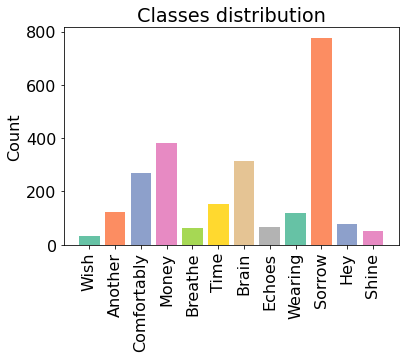

In [41]:
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

# Vertical bar plot of the classes distribution in y
plt.title('Classes distribution')
plt.bar(label_mapping.keys(), np.bincount(y), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

In [42]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)
print(X_train.shape)
print(X_test.shape)

# Compute the class weights in order to balance loss during training
labels = np.unique(np.fromiter([t for t in y_train], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_train)))
print(class_weights)

# Convert the sparse labels to categorical values
y = tfk.utils.to_categorical(y)
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(2064, 36, 6)
(365, 36, 6)
{0: 5.931034482758621, 1: 1.638095238095238, 2: 0.7510917030567685, 3: 0.5308641975308642, 4: 3.2452830188679247, 5: 1.323076923076923, 6: 0.6466165413533834, 7: 2.9655172413793105, 8: 1.6862745098039216, 9: 0.2606060606060606, 10: 2.646153846153846, 11: 4.0}
(2064, 12)
(365, 12)


#### Metadata

In [43]:
input_shape = X_train.shape[1:]
n_timestamps, n_features = input_shape
classes = y_train.shape[-1]
batch_size = 512
epochs = 200

# Define the K-fold Cross Validator
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

#### Data scaling

In [44]:
scaling = False

if scaling:
    n_instances_train = X_train.shape[0]
    n_instances_test = X_test.shape[0]
    X_train = np.reshape(X_train, newshape=(-1, n_features))
    X_test = np.reshape(X_test, newshape=(-1, n_features))
    print(X_train.shape, X_test.shape, sep=', ')
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.reshape(X_train, newshape=(n_instances_train, n_timestamps, n_features))
    X_test = np.reshape(X_test, newshape=(n_instances_test, n_timestamps, n_features))

#### Data reshaping

In [45]:
reshaping = False

if reshaping:
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 6, 6
    assert n_steps * n_length == n_timestamps
    X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
    input_shape = X_train.shape[1:]

#### Support functions

In [46]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

def plot_cm(model):
    # Predict the test set with the LSTM
    predictions = model.predict(X_test)
    predictions.shape

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average=None)
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), annot=True, fmt="d")
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

#### Classifier

In [47]:
# we advice to choose what parameters to change and include them directly among the attributes of this function
def build_TS_classifier(input_shape, classes, bi, n_cells, n_dense, lr):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # Convolutional part
    '''
    x = tfkl.Conv1D(64,3,padding='same',activation='relu')(input_layer)
    x = tfkl.Conv1D(64,3,padding='same',activation='relu')(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(128,3,padding='same',activation='relu')(x)
    x = tfkl.Conv1D(128,3,padding='same',activation='relu')(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(256,3,padding='same',activation='relu')(x)
    x = tfkl.Conv1D(256,3,padding='same',activation='relu')(x)
    x = tfkl.Conv1D(256,3,padding='same',activation='relu')(x)
    x = tfkl.GlobalAveragePooling1D()(x)
    '''
    
    # LSTM module
    if bi == 0:
        x = tfkl.LSTM(n_cells, return_sequences=True)(input_layer)
    else:
        x = tfkl.Bidirectional(tfkl.LSTM(n_cells, return_sequences=True))(input_layer)
    x = tfkl.Flatten()(x)
    
    # Classifier
    x = tfkl.Dropout(0.5)(x)
    for i in range(n_dense):
        x = tfkl.Dense(256, activation='relu')(x)
    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='cnn_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(lr), metrics='accuracy')

    # Return the model
    return model

Epoch 1/200
5/5 [==============================] - 4s 287ms/step - loss: 2.1691 - accuracy: 0.3362 - val_loss: 1.6873 - val_accuracy: 0.4877
Epoch 2/200
5/5 [==============================] - 1s 149ms/step - loss: 1.2394 - accuracy: 0.5862 - val_loss: 1.4488 - val_accuracy: 0.5151
Epoch 3/200
5/5 [==============================] - 1s 145ms/step - loss: 1.0507 - accuracy: 0.6381 - val_loss: 1.3166 - val_accuracy: 0.5699
Epoch 4/200
5/5 [==============================] - 1s 149ms/step - loss: 0.8163 - accuracy: 0.7326 - val_loss: 1.3275 - val_accuracy: 0.6164
Epoch 5/200
5/5 [==============================] - 1s 147ms/step - loss: 0.7196 - accuracy: 0.7573 - val_loss: 1.3729 - val_accuracy: 0.5781
Epoch 6/200
5/5 [==============================] - 1s 145ms/step - loss: 0.6415 - accuracy: 0.7820 - val_loss: 1.3836 - val_accuracy: 0.5836
Epoch 7/200
5/5 [==============================] - 1s 145ms/step - loss: 0.5606 - accuracy: 0.8135 - val_loss: 1.4122 - val_accuracy: 0.5616
Epoch 8/200
5

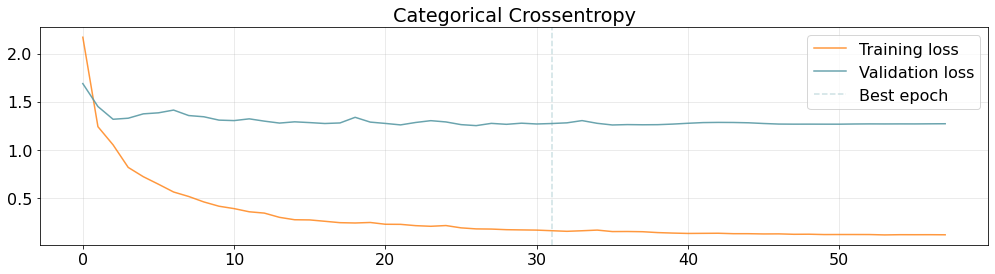

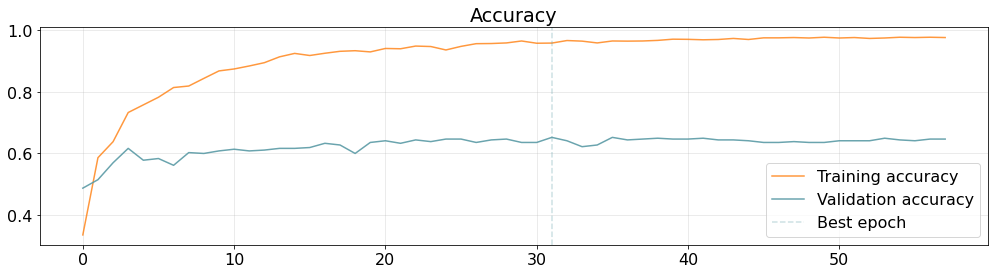

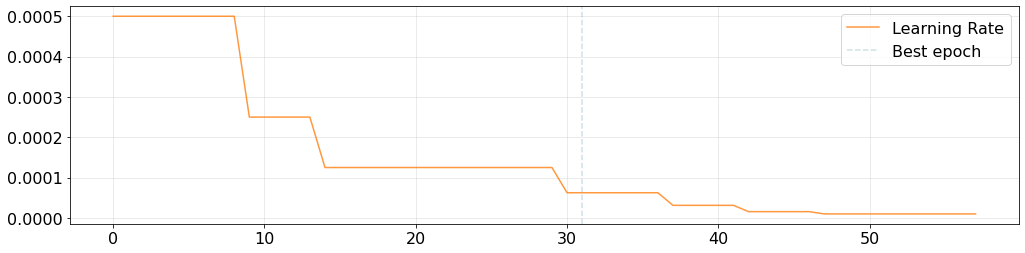

Accuracy: 0.6521
Precision: 0.6611
Recall: 0.5046
F1: [0.3333 0.5625 0.8941 0.4724 0.     0.3243 0.781  0.3077 0.8571 0.6935
 0.6316 0.6154]


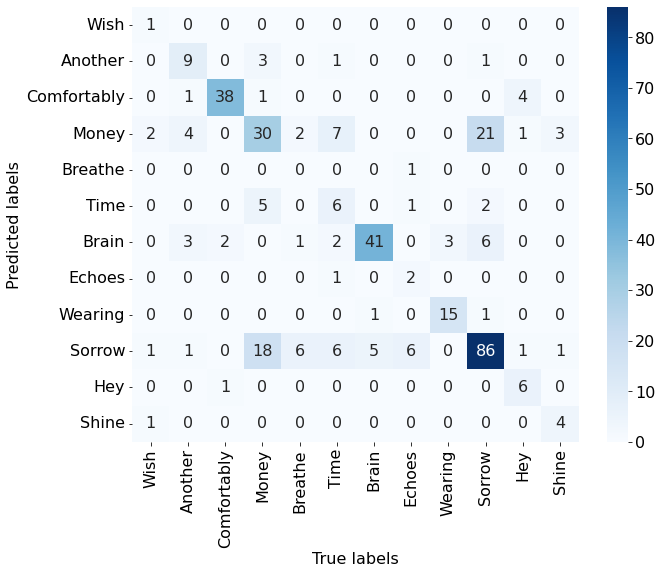

In [48]:
cross_val = False
final_train = False

if cross_val:
    # K-fold Cross Validation model evaluation
    best_acc = 0
    best_model = None
    best_history =  []
    
    i = 0
    for bi in [1, 0]:
        for n_cells in [32, 64, 128, 256, 512, 1024]:
            for n_dense in [0, 1, 2, 3]:
                for lr in np.arange(2e-4, 2e-3):
                    i += 1
                    print(f'°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° MODEL {i} °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')

                    acc_per_fold = []
                    loss_per_fold = []
                    fold_no = 1
                    for train, test in kfold.split(X, y):

                        # Define the model architecture
                        model = build_TS_classifier(input_shape, classes, bi, n_cells, n_dense, lr)

                        # Generate a print
                        print(f'Training for fold {fold_no} ...', end=' ')

                        # Fit data to model
                        history = model.fit(X[train], y[train],
                                  batch_size = batch_size,
                                  epochs = epochs,
                                  validation_data = (X[test], y[test]),
                                  #class_weight = class_weights,
                                  verbose=0,
                                  callbacks = [
                                      tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=26, restore_best_weights=True),
                                      tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
                                  ]
                        ).history

                        # Generate generalization metrics
                        scores = model.evaluate(X[test], y[test], verbose=0)
                        print(f'score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
                        acc_per_fold.append(scores[1] * 100)
                        loss_per_fold.append(scores[0])

                        # Increase fold number
                        fold_no = fold_no + 1
                        if fold_no <= num_folds + 1:
                            print('------------------------------------------------------------------------')

                    print('\nAverage scores for all folds:')
                    acc = np.mean(acc_per_fold)
                    print(f'> Accuracy: {acc} (+- {np.std(acc_per_fold)})')
                    print(f'> Loss: {np.mean(loss_per_fold)}')
                    if acc > best_acc:
                        best_acc = acc
                        best_model = model
                        best_history = history
                    print('°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')
    # RETRAIN THE BEST MODEL ON THE WHOLE DATASET
    if final_train:
        best_model.fit(
            x = X,
            y = y,
            batch_size = batch_size,
            epochs = epochs,
            #class_weight = class_weights,
            callbacks = [
                tfk.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=26, restore_best_weights=True),
                tfk.callbacks.ReduceLROnPlateau(monitor='accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
            ]
        )
    
else:
    best_model = build_TS_classifier(input_shape, classes, 1, 1024, 0, 5e-4)
    
    # Train the model
    best_history = best_model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = (X_test, y_test),
        #class_weight = class_weights,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=26, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
        ]
    ).history

# Plot results
best_model.summary()
plot_history(best_history)
plot_cm(best_model)